In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
df = pd.read_csv('/gdrive/My Drive/Colab Notebooks/AMZN.csv')
df = df.sort_values('Date')
df = df[:-300]
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-05-20,82.169998,82.699997,80.029999,80.720001,80.720001,7912200
1,2008-05-21,80.370003,81.150002,77.500000,78.300003,78.300003,7070500
2,2008-05-22,78.680000,79.690002,78.000000,79.260002,79.260002,5390600
3,2008-05-23,78.550003,78.870003,77.430000,78.349998,78.349998,6331900
4,2008-05-27,78.260002,80.900002,77.970001,80.620003,80.620003,10108200
...,...,...,...,...,...,...,...
2968,2020-03-05,1933.000000,1960.719971,1910.000000,1924.030029,1924.030029,4748200
2969,2020-03-06,1875.000000,1910.869995,1869.500000,1901.089966,1901.089966,5273600
2970,2020-03-09,1773.859985,1862.770020,1761.290039,1800.609985,1800.609985,7813200
2971,2020-03-10,1870.880005,1894.270020,1818.170044,1891.819946,1891.819946,7133300


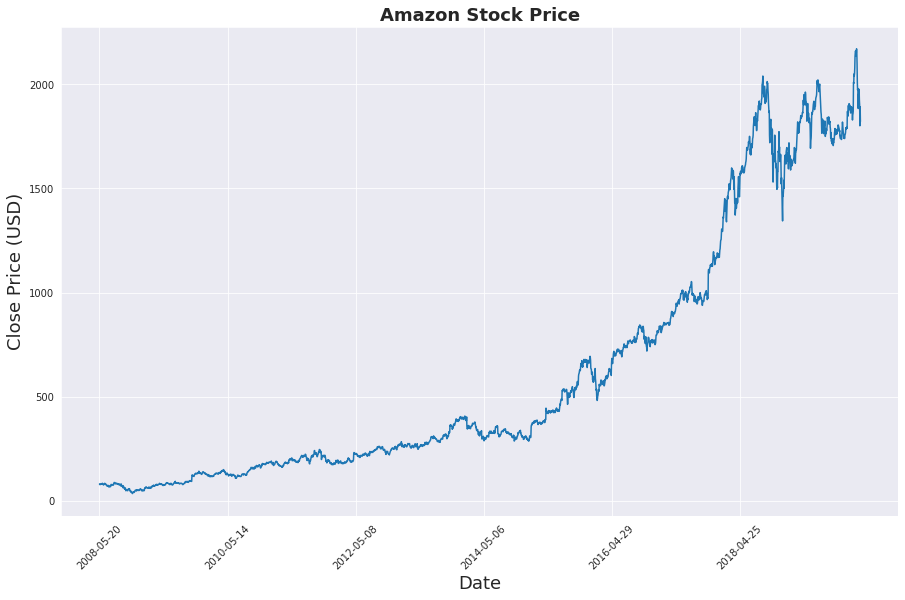

In [3]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(df[['Close']])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [4]:
price = df[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973 entries, 0 to 2972
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2973 non-null   float64
dtypes: float64(1)
memory usage: 46.5 KB


In [5]:
def generate_lookback(df, lb):
    df_n = df.copy()
    for n in range(1, lb + 1):
        df_n[f"lb{n}"] = df_n["Close"].shift(n)
    df_n = df_n.iloc[lb:]
    return df_n

df_generated = generate_lookback(price, 30)
df_generated

,Close,lb1,lb2,lb3,lb4,lb5,lb6,lb7,lb8,lb9,lb10,lb11,lb12,lb13,lb14,lb15,lb16,lb17,lb18,lb19,lb20,lb21,lb22,lb23,lb24,lb25,lb26,lb27,lb28,lb29,lb30
30,71.440002,73.620003,73.330002,74.660004,76.300003,80.510002,79.639999,80.680000,81.099998,84.260002,82.519997,82.970001,81.699997,79.169998,76.150002,77.279999,79.620003,79.430000,80.629997,84.510002,81.500000,80.110001,80.230003,81.620003,80.349998,80.080002,80.620003,78.349998,79.260002,78.300003,80.720001
31,72.000000,71.440002,73.620003,73.330002,74.660004,76.300003,80.510002,79.639999,80.680000,81.099998,84.260002,82.519997,82.970001,81.699997,79.169998,76.150002,77.279999,79.620003,79.430000,80.629997,84.510002,81.500000,80.110001,80.230003,81.620003,80.349998,80.080002,80.620003,78.349998,79.260002,78.300003
32,72.489998,72.000000,71.440002,73.620003,73.330002,74.660004,76.300003,80.510002,79.639999,80.680000,81.099998,84.260002,82.519997,82.970001,81.699997,79.169998,76.150002,77.279999,79.620003,79.430000,80.629997,84.510002,81.500000,80.110001,80.230003,81.620003,80.349998,80.080002,80.620003,78.349998,79.260002
33,75.040001,72.489998,72.000000,71.440002,73.620003,73.330002,74.660004,76.300003,80.510002,79.639999,80.680000,81.099998,84.260002,82.519997,82.970001,81.699997,79.169998,76.150002,77.279999,79.620003,79.430000,80.629997,84.510002,81.500000,80.110001,80.230003,81.620003,80.349998,80.080002,80.620003,78.349998
34,70.610001,75.040001,72.489998,72.000000,71.440002,73.620003,73.330002,74.660004,76.300003,80.510002,79.639999,80.680000,81.099998,84.260002,82.519997,82.970001,81.699997,79.169998,76.150002,77.279999,79.620003,79.430000,80.629997,84.510002,81.500000,80.110001,80.230003,81.620003,80.349998,80.080002,80.620003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,1924.030029,1975.829956,1908.989990,1953.949951,1883.750000,1884.300049,1979.589966,1972.739990,2009.290039,2095.969971,2153.100098,2170.219971,2155.669922,2134.870117,2149.870117,2160.000000,2150.800049,2133.909912,2079.280029,2050.229980,2039.869995,2049.669922,2004.199951,2008.719971,1870.680054,1858.000000,1853.250000,1828.339966,1861.640015,1884.579956,1887.459961
2969,1901.089966,1924.030029,1975.829956,1908.989990,1953.949951,1883.750000,1884.300049,1979.589966,1972.739990,2009.290039,2095.969971,2153.100098,2170.219971,2155.669922,2134.870117,2149.870117,2160.000000,2150.800049,2133.909912,2079.280029,2050.229980,2039.869995,2049.669922,2004.199951,2008.719971,1870.680054,1858.000000,1853.250000,1828.339966,1861.640015,1884.579956
2970,1800.609985,1901.089966,1924.030029,1975.829956,1908.989990,1953.949951,1883.750000,1884.300049,1979.589966,1972.739990,2009.290039,2095.969971,2153.100098,2170.219971,2155.669922,2134.870117,2149.870117,2160.000000,2150.800049,2133.909912,2079.280029,2050.229980,2039.869995,2049.669922,2004.199951,2008.719971,1870.680054,1858.000000,1853.250000,1828.339966,1861.640015
2971,1891.819946,1800.609985,1901.089966,1924.030029,1975.829956,1908.989990,1953.949951,1883.750000,1884.300049,1979.589966,1972.739990,2009.290039,2095.969971,2153.100098,2170.219971,2155.669922,2134.870117,2149.870117,2160.000000,2150.800049,2133.909912,2079.280029,2050.229980,2039.869995,2049.669922,2004.199951,2008.719971,1870.680054,1858.000000,1853.250000,1828.339966


In [6]:
X, y = df_generated.iloc[:, 1:].to_numpy(), df_generated.iloc[:, 0].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [7]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_train = scaler.fit_transform(X_train)
y_train = scaler.fit_transform(y_train[:, np.newaxis])

X_test = scaler.transform(X_test)
y_test = scaler.transform(y_test[:, np.newaxis])

In [8]:
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2648, 30)
y_train.shape =  (2648, 1)
x_test.shape =  (295, 30)
y_test.shape =  (295, 1)


In [9]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [10]:
INPUT_DIM = 30
HIDDEN_DIM = 32
NUM_LAYERS = 2
OUTPUT_DIM = 1
NUM_EPOCHS = 100
LEARNING_RATE = 0.01

class GRU(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(GRU, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn) = self.gru(x, (h0.detach()))
    out = self.fc(out[:, -1, :]) 

    return out

model = GRU(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUM_LAYERS)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
X_train_final = torch.reshape(X_train_tensor, (X_train_tensor.shape[0], 1, X_train_tensor.shape[1]))
hist = np.zeros(NUM_EPOCHS)

for t in range(1,NUM_EPOCHS+1):
  y_train_pred = model(X_train_final)

  loss = criterion(y_train_pred, y_train_tensor)
  if t%10 == 0:
    print("Epoch ", t, "MSE: ", loss.item())
  hist[t-1] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch  10 MSE:  0.04254579171538353
Epoch  20 MSE:  0.02330460585653782
Epoch  30 MSE:  0.0073313042521476746
Epoch  40 MSE:  0.005555328447371721
Epoch  50 MSE:  0.00340885273180902
Epoch  60 MSE:  0.0021280422806739807
Epoch  70 MSE:  0.0016821406316012144
Epoch  80 MSE:  0.0012806992745026946
Epoch  90 MSE:  0.0010508932173252106
Epoch  100 MSE:  0.0009189943084493279


In [13]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_tensor.detach().numpy()))

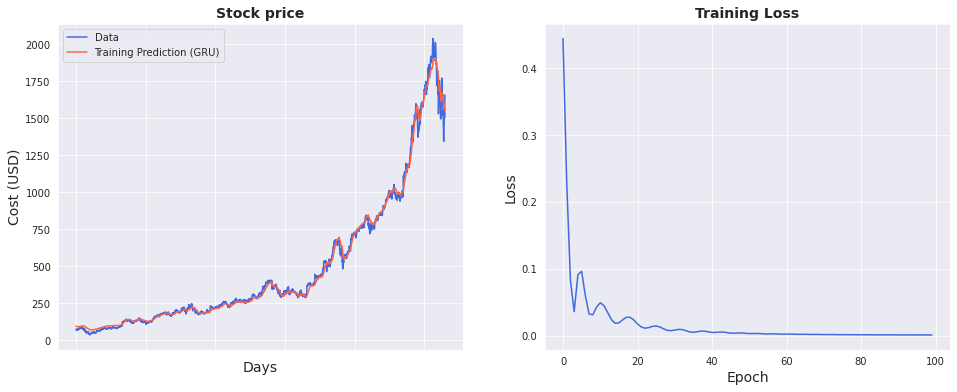

In [14]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [16]:
X_test_final = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))
y_test_pred = model(X_test_final)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_tensor.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_tensor.detach().numpy())

train_score = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print(f"Train Score: {train_score:.2f} RMSE")
test_score = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print(f"Test Score: {test_score:.2f} RMSE")

Train Score: 30.38 RMSE
Test Score: 69.94 RMSE


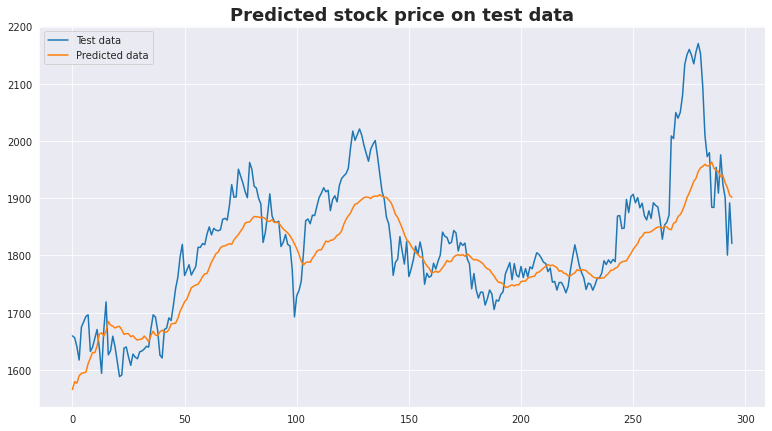

In [17]:
predict_test = pd.DataFrame(y_test_pred)
original_test = pd.DataFrame(y_test)

plt.figure(figsize=(13,7))
plt.plot(original_test, label="Test data")
plt.plot(predict_test, label="Predicted data")
plt.title("Predicted stock price on test data", fontsize=18, fontweight='bold')
plt.legend()
plt.show()